In [51]:
import scanpy as sc
import anndata
import numpy as np
from scipy import sparse
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn import set_config 
import time as tm
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.callbacks import EarlyStopping

In [3]:
dpt_sub=sc.read("../../temp_data/10.27_dpt_sub.h5ad")

In [4]:
dpt_sub.layers["log_count"]=dpt_sub.X

In [5]:
dpt_rf=sc.pp.subsample(dpt_sub,fraction=0.1,copy=True)

In [6]:
dataDf=dpt_rf.layers["counts"].toarray()

In [7]:
dpt_rf

AnnData object with n_obs × n_vars = 16620 × 17312
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'Sample', 'Project', 'Limb.Atlas', 'Organ', 'Tissue', 'Tissue.Specific.', 'Stage', 'Gene.type', 'Treatment', 'Age', 'Age.In.Detail.', 'Machine', 'Species', 'Isolation.approach', 'Digestion', 'Enzymes', 'Bone.Forming.Methods', 'Data.Source', 'Related.Assay', 'Origin', 'nCount_RNA', 'nFeature_RNA', 'paper_label', 'coarse_label', 'scDblFinder_class', 'short_id', 'temp_cluster', 'batch', 'batch_atlas', 'size_factors', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'new_totals_log', 'anno_level_1', 'anno_level_2', 'anno_level_3', 'anno_level_4', 'anno_level_5', 'mix_level_1', 'mix_level_2', 'merge_id_level3', 'merge_id_level4', 'merge_id_level5', 'cellid', 'leiden_clusters_level_1', 'leiden_clusters_level_2', 'lei

In [8]:
label=dpt_rf.obs["palantir_norm"]

In [9]:

X_train, X_test, y_train, y_test = train_test_split(
     dataDf, label, test_size=0.4, random_state=0)

In [10]:
rfr = RandomForestRegressor(n_jobs=-1)

R-squared: 0.9922365610684185


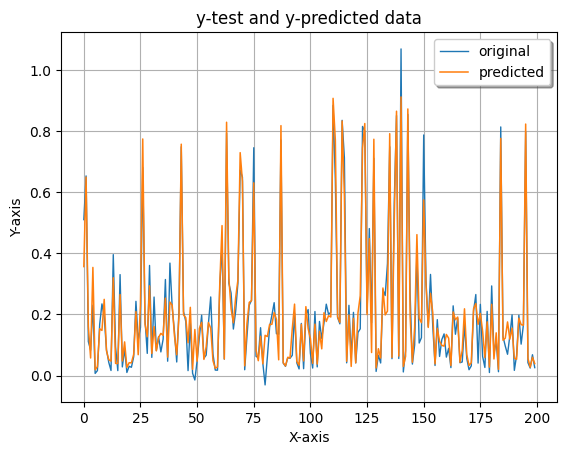

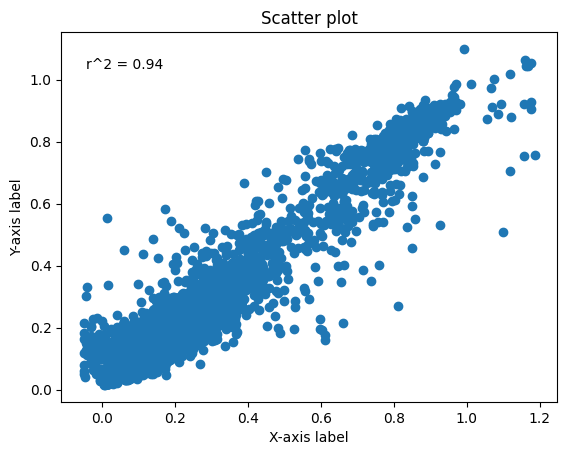

MSE:  0.003302518403880681
RMSE:  0.0016512592019403405
0.03571472038520373
0.9359388814120934


In [11]:
start=tm.time()
rfr.fit(X_train, y_train)
tr_time=tm.time()-start
start=tm.time()
ypred = rfr.predict(X_test)
ts_time=tm.time()-start
score = rfr.score(X_train, y_train)
print("R-squared:", score) 
x_ax = range(len(y_test[0:200]))
plt.plot(x_ax, y_test[0:200], linewidth=1, label="original")
plt.plot(x_ax, ypred[0:200], linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
plt.scatter(y_test, ypred)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter plot')
r2 = sklearn.metrics.r2_score(y_test, ypred)
plt.annotate('r^2 = {:.2f}'.format(r2), xy=(0.05, 0.90), xycoords='axes fraction')

# Display the plot
plt.show()
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
mae=mean_absolute_error(y_test, ypred)
print(mean_absolute_error(y_test, ypred))

print(r2)

In [13]:
rfr.feature_importances_

array([4.07830166e-08, 2.65366923e-05, 2.39217312e-06, ...,
       2.28673879e-06, 1.20204745e-05, 5.67062454e-05])

In [16]:
geneImport=pd.DataFrame({"gene":dpt_rf.var_names,"importance":rfr.feature_importances_})

In [20]:
geneImport=geneImport.sort_values("importance",ascending=False)

In [21]:
geneImport.to_csv("../../important_processed_data/10.29_rf_importance_gene.csv")

In [27]:
geneImport

,gene,importance
3451,Col22a1,0.372344
8182,Ifitm5,0.255632
1126,Adipoq,0.039729
3448,Col1a1,0.037051
14503,Spp1,0.016517
...,...,...
3872,D030045P18Rik,0.000000
14387,Soga3,0.000000
660,9930013L23Rik,0.000000
8607,Kcnj14,0.000000


In [34]:
sum(geneImport["importance"]>0.000008)

2146

In [35]:
gene=geneImport["gene"][geneImport["importance"]>0.000008]

In [37]:
dpt_sub=dpt_sub[:,gene]

In [44]:
dataDf=dpt_sub.layers["counts"].toarray()
label=dpt_sub.obs["palantir_norm"]
X_train, X_test, y_train, y_test = train_test_split(
     dataDf, label, test_size=0.4, random_state=0)

KeyboardInterrupt: 

In [53]:
X_val, X_test2, Y_val, Y_test2 = train_test_split(X_test, y_test, test_size=0.5)

In [76]:
model_2 = Sequential([
    Dense(1000, activation='relu', input_shape=(2146,)),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])

model_2.compile(loss='mean_squared_error', optimizer='adam')
start=tm.time()              


early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist_2 = model_2.fit(X_train, y_train,
          batch_size=200, epochs=50,
          validation_data=(X_val, Y_val),callbacks=[early_stopping])
            

tr_time=tm.time()-start

Epoch 1/50
499/499 [==============================] - 23s 42ms/step - loss: 0.3811 - val_loss: 0.0509
Epoch 2/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0291 - val_loss: 0.0184
Epoch 3/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0143 - val_loss: 0.0112
Epoch 4/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0096 - val_loss: 0.0084
Epoch 5/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0072 - val_loss: 0.0066
Epoch 6/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0059 - val_loss: 0.0058
Epoch 7/50
499/499 [==============================] - 20s 41ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 8/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 9/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0043 - val_loss: 0.0043
Epoch 10/50
499/499 [==============================] - 20s 40ms/step - loss: 0.004

2078/2078 [==============================] - 21s 10ms/step


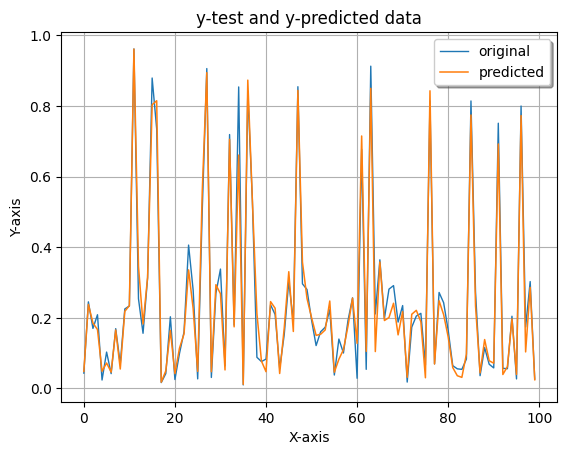

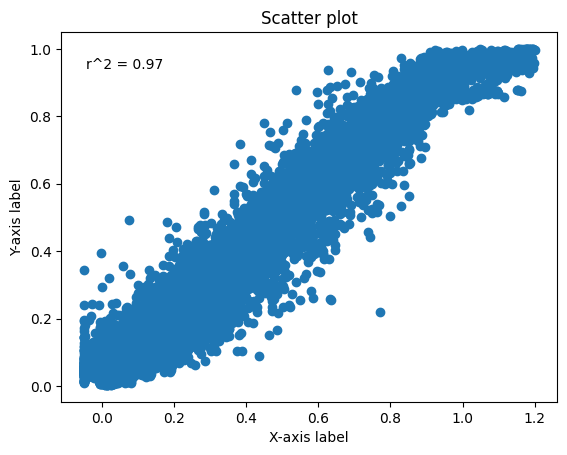

MSE:  0.0014576392998290138
RMSE:  0.0007288196499145069
0.02550950600575379
0.9729182542599867


In [77]:
start=tm.time()
ypred = model_2.predict(X_test)
ts_time=tm.time()-start
x_ax = range(len(y_test[0:100]))
plt.plot(x_ax, y_test[0:100], linewidth=1, label="original")
plt.plot(x_ax, ypred[0:100], linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
plt.scatter(y_test, ypred)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter plot')
r2 = sklearn.metrics.r2_score(y_test, ypred)
plt.annotate('r^2 = {:.2f}'.format(r2), xy=(0.05, 0.90), xycoords='axes fraction')

# Display the plot
plt.show()
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
mae=mean_absolute_error(y_test, ypred)
print(mean_absolute_error(y_test, ypred))

print(r2)

In [87]:
model_1 = Sequential([
    Dense(1000, activation='relu', input_shape=(2146,)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])
model_4 = Sequential([
    Dense(1000, activation='relu', input_shape=(2146,)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])

model_3 = Sequential([
    Dense(1000, activation='relu', input_shape=(2146,)),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])

model_5 = Sequential([
    Dense(2000, activation='relu', input_shape=(2146,)),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])

model_6 = Sequential([
    Dense(2000, activation='relu', input_shape=(2146,)),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])

model_7 = Sequential([
    Dense(2000, activation='relu', input_shape=(2146,)),
    Dense(2000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])

model_8 = Sequential([
    Dense(2000, activation='relu', input_shape=(2146,)),
    Dense(2000, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])

In [88]:
modelList=[model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8]
for i in range(7):
    model=modelList[i]
    print(f"working on model{i}")
    model.compile(loss='mean_squared_error', optimizer='adam')
    start=tm.time()              
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    hist = model.fit(X_train, y_train,
          batch_size=200, epochs=50,
          validation_data=(X_val, Y_val),callbacks=[early_stopping])
    tr_time=tm.time()-start
    start=tm.time()
    ypred = model.predict(X_test)
    ts_time=tm.time()-start
    r2 = sklearn.metrics.r2_score(y_test, ypred)
    mse = mean_squared_error(y_test, ypred)
    mae=mean_absolute_error(y_test, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    print(mean_absolute_error(y_test, ypred))
    print(r2)
    metric_dict={"R_square":r2,"MSE":mse,"RMSE": mse*(1/2.0),"MAE":mae,"Train time":tr_time,"Predict time":ts_time}
    metric_table=pd.DataFrame.from_dict(data=metric_dict, orient='index', columns=['Value'])
    metric_table.to_csv(f"../result/10.29_pesudotime_predict/model{i}.csv")
    model.save(f"../result/10.29_pesudotime_predict/model/model{i}")

working on model{i}
Epoch 1/50
499/499 [==============================] - 17s 32ms/step - loss: 0.2288 - val_loss: 0.1214
Epoch 2/50
499/499 [==============================] - 15s 30ms/step - loss: 0.1187 - val_loss: 0.1109
Epoch 3/50
499/499 [==============================] - 15s 30ms/step - loss: 0.1074 - val_loss: 0.1045
Epoch 4/50
499/499 [==============================] - 15s 30ms/step - loss: 0.1116 - val_loss: 0.1089
Epoch 5/50
499/499 [==============================] - 15s 30ms/step - loss: 0.1071 - val_loss: 0.1050
Epoch 6/50
499/499 [==============================] - 15s 30ms/step - loss: 0.1047 - val_loss: 0.1036
Epoch 7/50
499/499 [==============================] - 15s 30ms/step - loss: 0.1037 - val_loss: 0.1029
Epoch 8/50
499/499 [==============================] - 14s 29ms/step - loss: 0.1631 - val_loss: 0.1050
Epoch 9/50
499/499 [==============================] - 15s 30ms/step - loss: 0.1046 - val_loss: 0.1035
Epoch 10/50
499/499 [==============================] - 15s 30m

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



499/499 [==============================] - 15s 29ms/step - loss: 0.0016 - val_loss: 0.0020
Epoch 26/50
499/499 [==============================] - 15s 30ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 27/50
499/499 [==============================] - 15s 30ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 28/50
499/499 [==============================] - 15s 30ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 29/50
499/499 [==============================] - 15s 30ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 30/50
499/499 [==============================] - 15s 30ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 31/50
499/499 [==============================] - 15s 29ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 32/50
499/499 [==============================] - 15s 30ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 33/50
499/499 [==============================] - 15s 29ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 34/50
499/499 [==============================] - 15s 30ms/step - loss: 0.0013 -

INFO:tensorflow:Assets written to: ../result/10.29_pesudotime_predict/model/model0/assets


working on model{i}
Epoch 1/50
499/499 [==============================] - 22s 40ms/step - loss: 0.0026 - val_loss: 0.0033
Epoch 2/50
499/499 [==============================] - 19s 39ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 3/50
499/499 [==============================] - 19s 39ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 4/50
499/499 [==============================] - 19s 39ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 5/50
499/499 [==============================] - 19s 38ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 6/50
499/499 [==============================] - 19s 39ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 7/50
499/499 [==============================] - 19s 39ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 8/50
499/499 [==============================] - 19s 39ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 9/50
499/499 [==============================] - 19s 38ms/step - loss: 0.0024 - val_loss: 0.0032
Epoch 10/50
499/499 [==============================] - 19s 39m

INFO:tensorflow:Assets written to: ../result/10.29_pesudotime_predict/model/model1/assets


working on model{i}
Epoch 1/50
499/499 [==============================] - 23s 41ms/step - loss: 0.4394 - val_loss: 0.0627
Epoch 2/50
499/499 [==============================] - 20s 41ms/step - loss: 0.0316 - val_loss: 0.0155
Epoch 3/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0110 - val_loss: 0.0079
Epoch 4/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0065 - val_loss: 0.0056
Epoch 5/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0052 - val_loss: 0.0049
Epoch 6/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 7/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0044 - val_loss: 0.0046
Epoch 8/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0043 - val_loss: 0.0044
Epoch 9/50
499/499 [==============================] - 20s 40ms/step - loss: 0.0041 - val_loss: 0.0044
Epoch 10/50
499/499 [==============================] - 20s 40m

INFO:tensorflow:Assets written to: ../result/10.29_pesudotime_predict/model/model2/assets


working on model{i}
Epoch 1/50
499/499 [==============================] - 18s 33ms/step - loss: 0.2787 - val_loss: 0.1299
Epoch 2/50
499/499 [==============================] - 15s 31ms/step - loss: 0.0920 - val_loss: 0.0196
Epoch 3/50
499/499 [==============================] - 16s 32ms/step - loss: 0.0113 - val_loss: 0.0072
Epoch 4/50
499/499 [==============================] - 16s 31ms/step - loss: 0.0057 - val_loss: 0.0048
Epoch 5/50
499/499 [==============================] - 16s 32ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/50
499/499 [==============================] - 16s 32ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 7/50
499/499 [==============================] - 16s 31ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/50
499/499 [==============================] - 16s 32ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/50
499/499 [==============================] - 16s 32ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/50
499/499 [==============================] - 16s 32m

INFO:tensorflow:Assets written to: ../result/10.29_pesudotime_predict/model/model3/assets


working on model{i}
Epoch 1/50
499/499 [==============================] - 34s 63ms/step - loss: 0.4016 - val_loss: 0.0857
Epoch 2/50
499/499 [==============================] - 30s 61ms/step - loss: 0.0575 - val_loss: 0.0397
Epoch 3/50
499/499 [==============================] - 31s 63ms/step - loss: 0.0309 - val_loss: 0.0240
Epoch 4/50
499/499 [==============================] - 31s 63ms/step - loss: 0.0199 - val_loss: 0.0167
Epoch 5/50
499/499 [==============================] - 31s 63ms/step - loss: 0.0143 - val_loss: 0.0132
Epoch 6/50
499/499 [==============================] - 30s 61ms/step - loss: 0.0109 - val_loss: 0.0097
Epoch 7/50
499/499 [==============================] - 30s 61ms/step - loss: 0.0089 - val_loss: 0.0082
Epoch 8/50
499/499 [==============================] - 31s 62ms/step - loss: 0.0076 - val_loss: 0.0074
Epoch 9/50
499/499 [==============================] - 30s 60ms/step - loss: 0.0070 - val_loss: 0.0068
Epoch 10/50
499/499 [==============================] - 31s 62m

INFO:tensorflow:Assets written to: ../result/10.29_pesudotime_predict/model/model4/assets


working on model{i}
Epoch 1/50
499/499 [==============================] - 37s 68ms/step - loss: 0.2461 - val_loss: 0.0196
Epoch 2/50
499/499 [==============================] - 33s 66ms/step - loss: 0.0148 - val_loss: 0.0121
Epoch 3/50
499/499 [==============================] - 33s 67ms/step - loss: 0.0112 - val_loss: 0.0107
Epoch 4/50
499/499 [==============================] - 33s 66ms/step - loss: 0.0105 - val_loss: 0.0103
Epoch 5/50
499/499 [==============================] - 33s 67ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 6/50
499/499 [==============================] - 33s 67ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 7/50
499/499 [==============================] - 34s 67ms/step - loss: 0.0089 - val_loss: 0.0088
Epoch 8/50
499/499 [==============================] - 33s 66ms/step - loss: 0.0087 - val_loss: 0.0088
Epoch 9/50
499/499 [==============================] - 34s 68ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 10/50
499/499 [==============================] - 34s 68m

INFO:tensorflow:Assets written to: ../result/10.29_pesudotime_predict/model/model5/assets


working on model{i}
Epoch 1/50
499/499 [==============================] - 54s 101ms/step - loss: 0.6430 - val_loss: 0.1763
Epoch 2/50
499/499 [==============================] - 50s 101ms/step - loss: 0.1326 - val_loss: 0.1021
Epoch 3/50
499/499 [==============================] - 50s 99ms/step - loss: 0.0851 - val_loss: 0.0715
Epoch 4/50
499/499 [==============================] - 49s 98ms/step - loss: 0.0617 - val_loss: 0.0536
Epoch 5/50
499/499 [==============================] - 49s 98ms/step - loss: 0.0472 - val_loss: 0.0419
Epoch 6/50
499/499 [==============================] - 50s 99ms/step - loss: 0.0373 - val_loss: 0.0334
Epoch 7/50
499/499 [==============================] - 49s 99ms/step - loss: 0.0301 - val_loss: 0.0273
Epoch 8/50
499/499 [==============================] - 49s 98ms/step - loss: 0.0247 - val_loss: 0.0226
Epoch 9/50
499/499 [==============================] - 50s 99ms/step - loss: 0.0208 - val_loss: 0.0195
Epoch 10/50
499/499 [==============================] - 49s 9

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [ ]:
for i in [6,7]:
    model=modelList[i]
    print(f"working on model{i}")
    model.compile(loss='mean_squared_error', optimizer='adam')
    start=tm.time()              
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    hist = model.fit(X_train, y_train,
          batch_size=200, epochs=50,
          validation_data=(X_val, Y_val),callbacks=[early_stopping])
    tr_time=tm.time()-start
    start=tm.time()
    ypred = model.predict(X_test)
    ts_time=tm.time()-start
    r2 = sklearn.metrics.r2_score(y_test, ypred)
    mse = mean_squared_error(y_test, ypred)
    mae=mean_absolute_error(y_test, ypred)
    print("MSE: ", mse)
    print("RMSE: ", mse*(1/2.0)) 
    print(mean_absolute_error(y_test, ypred))
    print(r2)
    metric_dict={"R_square":r2,"MSE":mse,"RMSE": mse*(1/2.0),"MAE":mae,"Train time":tr_time,"Predict time":ts_time}
    metric_table=pd.DataFrame.from_dict(data=metric_dict, orient='index', columns=['Value'])
    metric_table.to_csv(f"../result/10.29_pesudotime_predict/model{i}.csv")
    model.save(f"../result/10.29_pesudotime_predict/model/model{i}")

working on model6
Epoch 1/50
499/499 [==============================] - 55s 101ms/step - loss: 0.0090 - val_loss: 0.0093
Epoch 2/50
499/499 [==============================] - 49s 99ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 3/50
499/499 [==============================] - 49s 99ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 4/50
499/499 [==============================] - 49s 99ms/step - loss: 0.0088 - val_loss: 0.0099
Epoch 5/50
499/499 [==============================] - 49s 99ms/step - loss: 0.0088 - val_loss: 0.0095
Epoch 6/50
499/499 [==============================] - 50s 100ms/step - loss: 0.0088 - val_loss: 0.0094
Epoch 7/50
499/499 [==============================] - 49s 99ms/step - loss: 0.0088 - val_loss: 0.0093
Epoch 8/50
499/499 [==============================] - 49s 99ms/step - loss: 0.0087 - val_loss: 0.0093
Epoch 9/50
499/499 [==============================] - 49s 99ms/step - loss: 0.0087 - val_loss: 0.0092
Epoch 10/50
499/499 [==============================] - 49s 98m

In [91]:
model_9 = Sequential([
    Dense(1000, activation='relu', input_shape=(2146,)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])



model_9.compile(loss='mean_squared_error', optimizer='adam')
start=tm.time()              


early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist_2 = model_9.fit(X_train, y_train,
          batch_size=200, epochs=200,
          validation_data=(X_val, Y_val),callbacks=[early_stopping])
            

tr_time=tm.time()-start

Epoch 1/200
499/499 [==============================] - 18s 33ms/step - loss: 0.2987 - val_loss: 0.0907
Epoch 2/200
499/499 [==============================] - 16s 32ms/step - loss: 0.0412 - val_loss: 0.0136
Epoch 3/200
499/499 [==============================] - 16s 32ms/step - loss: 0.0090 - val_loss: 0.0068
Epoch 4/200
499/499 [==============================] - 16s 32ms/step - loss: 0.0054 - val_loss: 0.0048
Epoch 5/200
499/499 [==============================] - 16s 32ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 6/200
499/499 [==============================] - 16s 32ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/200
499/499 [==============================] - 16s 32ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/200
499/499 [==============================] - 16s 32ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 9/200
499/499 [==============================] - 16s 33ms/step - loss: 0.0028 - val_loss: 0.0029
Epoch 10/200
499/499 [==============================] - 16s 32ms/step - l

2078/2078 [==============================] - 17s 8ms/step


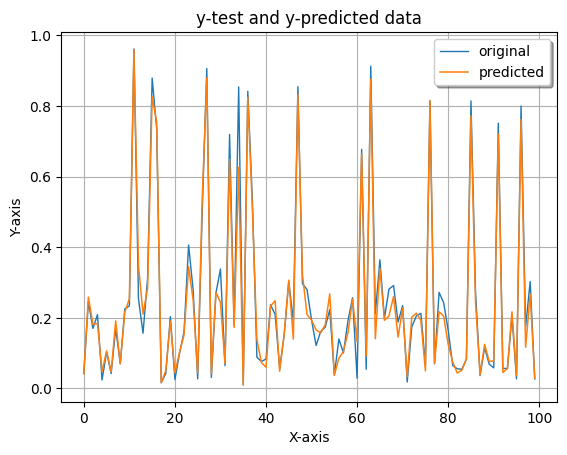

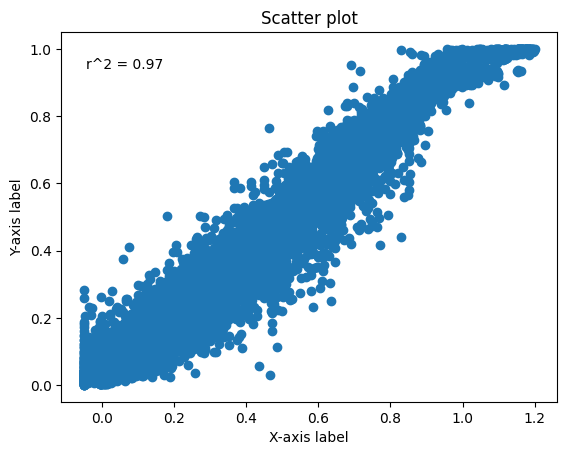

MSE:  0.0014290978182508688
RMSE:  0.0007145489091254344
0.025278978332238165
0.9734485316387822


In [96]:
start=tm.time()
ypred = model_9.predict(X_test)
ts_time=tm.time()-start
x_ax = range(len(y_test[0:100]))
plt.plot(x_ax, y_test[0:100], linewidth=1, label="original")
plt.plot(x_ax, ypred[0:100], linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
plt.scatter(y_test, ypred)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter plot')
r2 = sklearn.metrics.r2_score(y_test, ypred)
plt.annotate('r^2 = {:.2f}'.format(r2), xy=(0.05, 0.90), xycoords='axes fraction')

# Display the plot
plt.show()
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
mae=mean_absolute_error(y_test, ypred)
print(mean_absolute_error(y_test, ypred))

print(r2)

In [95]:
model_10 = Sequential([
    Dense(1000, activation='relu', input_shape=(2146,)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.001)),
])



model_10.compile(loss='mean_squared_error', optimizer='adam')
start=tm.time()              


early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist_2 = model_10.fit(X_train, y_train,
          batch_size=200, epochs=50,
          validation_data=(X_val, Y_val),callbacks=[early_stopping])
            

tr_time=tm.time()-start

Epoch 1/50
499/499 [==============================] - 18s 33ms/step - loss: 26.7114 - val_loss: 1.3462
Epoch 2/50
499/499 [==============================] - 16s 32ms/step - loss: 1.2335 - val_loss: 2.1049
Epoch 3/50
499/499 [==============================] - 16s 33ms/step - loss: 1.0821 - val_loss: 0.9495
Epoch 4/50
499/499 [==============================] - 16s 33ms/step - loss: 0.9723 - val_loss: 0.9137
Epoch 5/50
499/499 [==============================] - 16s 32ms/step - loss: 0.9747 - val_loss: 0.9844
Epoch 6/50
499/499 [==============================] - 16s 33ms/step - loss: 0.8885 - val_loss: 0.8559
Epoch 7/50
499/499 [==============================] - 16s 32ms/step - loss: 0.9205 - val_loss: 0.8157
Epoch 8/50
499/499 [==============================] - 16s 33ms/step - loss: 0.8155 - val_loss: 0.7818
Epoch 9/50
499/499 [==============================] - 16s 32ms/step - loss: 0.7822 - val_loss: 0.7578
Epoch 10/50
499/499 [==============================] - 16s 33ms/step - loss: 0.74

2078/2078 [==============================] - 17s 8ms/step


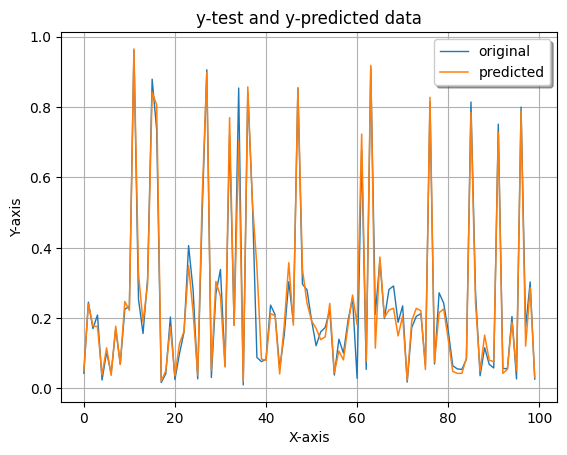

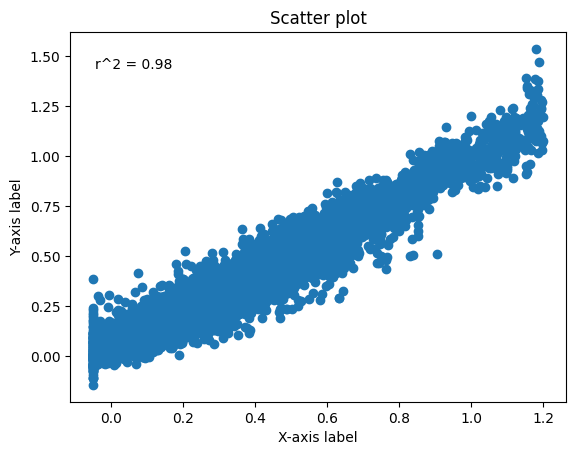

MSE:  0.0013178437645175376
RMSE:  0.0006589218822587688
0.024308133145386025
0.9755155409435569


In [97]:
start=tm.time()
ypred = model_10.predict(X_test)
ts_time=tm.time()-start
x_ax = range(len(y_test[0:100]))
plt.plot(x_ax, y_test[0:100], linewidth=1, label="original")
plt.plot(x_ax, ypred[0:100], linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
plt.scatter(y_test, ypred)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter plot')
r2 = sklearn.metrics.r2_score(y_test, ypred)
plt.annotate('r^2 = {:.2f}'.format(r2), xy=(0.05, 0.90), xycoords='axes fraction')

# Display the plot
plt.show()
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
mae=mean_absolute_error(y_test, ypred)
print(mean_absolute_error(y_test, ypred))

print(r2)

In [100]:
model_11 = Sequential([
    Dense(1000, activation='relu', input_shape=(2146,)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='linear', kernel_regularizer=regularizers.l2(0.001)),
])



model_11.compile(loss='mean_squared_error', optimizer='adam')
start=tm.time()              


early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist_2 = model_11.fit(X_train, y_train,
          batch_size=100, epochs=300,
          validation_data=(X_val, Y_val),callbacks=[early_stopping])
            

tr_time=tm.time()-start

Epoch 1/300
998/998 [==============================] - 31s 30ms/step - loss: 21.0156 - val_loss: 1.0468
Epoch 2/300
998/998 [==============================] - 29s 29ms/step - loss: 1.2507 - val_loss: 0.9633
Epoch 3/300
998/998 [==============================] - 28s 28ms/step - loss: 0.9797 - val_loss: 0.9369
Epoch 4/300
998/998 [==============================] - 28s 28ms/step - loss: 0.8708 - val_loss: 0.8271
Epoch 5/300
998/998 [==============================] - 29s 29ms/step - loss: 0.8473 - val_loss: 0.7632
Epoch 6/300
998/998 [==============================] - 29s 29ms/step - loss: 0.7394 - val_loss: 0.6956
Epoch 7/300
998/998 [==============================] - 29s 29ms/step - loss: 0.6581 - val_loss: 0.6382
Epoch 8/300
998/998 [==============================] - 29s 29ms/step - loss: 0.5860 - val_loss: 0.5555
Epoch 9/300
998/998 [==============================] - 28s 28ms/step - loss: 0.5033 - val_loss: 0.4575
Epoch 10/300
998/998 [==============================] - 29s 29ms/step - 

2078/2078 [==============================] - 17s 8ms/step


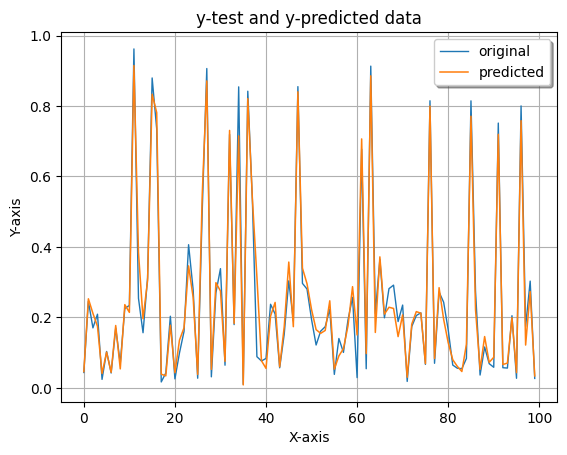

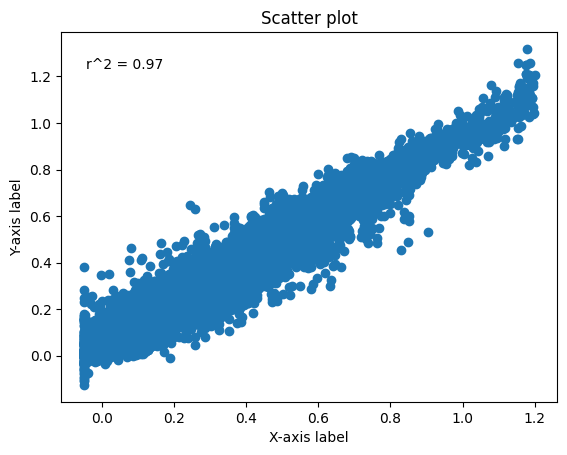

MSE:  0.00140496624973389
RMSE:  0.000702483124866945
0.025950987439473543
0.9738968764405183


In [101]:
start=tm.time()
ypred = model_11.predict(X_test)
ts_time=tm.time()-start
x_ax = range(len(y_test[0:100]))
plt.plot(x_ax, y_test[0:100], linewidth=1, label="original")
plt.plot(x_ax, ypred[0:100], linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
plt.scatter(y_test, ypred)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter plot')
r2 = sklearn.metrics.r2_score(y_test, ypred)
plt.annotate('r^2 = {:.2f}'.format(r2), xy=(0.05, 0.90), xycoords='axes fraction')

# Display the plot
plt.show()
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
mae=mean_absolute_error(y_test, ypred)
print(mean_absolute_error(y_test, ypred))

print(r2)

In [102]:
scaled_label = (label - min(label)) / (max(label) - min(label))

In [103]:
scaled_label

Unnamed: 0
Suture2021_Farmer_E17_AAACCTGCAGACTCGC-1_1-0    0.185433
Suture2021_Farmer_E17_AAACCTGGTGGTCTCG-1_1-0    0.496789
Suture2021_Farmer_E17_AAACCTGTCACCACCT-1_1-0    0.528830
Suture2021_Farmer_E17_AAAGATGAGGGAACGG-1_1-0    0.289856
Suture2021_Farmer_E17_AAAGTAGTCGGAGCAA-1_1-0    0.222011
                                                  ...   
TTTGACTGTATTTCCT-1_5-1-2                        0.227762
TTTGACTGTTGCATTG-1_5-1-2                        0.277540
TTTGACTTCTTGGGCG-1_5-1-2                        0.392902
TTTGGAGCAGCGACAA-1_5-1-2                        0.735764
TTTGGTTCACTACTTT-1_5-1-2                        0.540271
Name: palantir_norm, Length: 166204, dtype: float64

In [104]:
X_train_bk=X_train
X_test_bk=X_test
y_train_bk=y_train
y_test_bk=y_test
X_val_bk=X_val
X_test2_bk=X_test2
Y_val_bk=Y_val
Y_test2_bk = Y_test2

X_train, X_test, y_train, y_test = train_test_split(
     dataDf, scaled_label, test_size=0.4, random_state=0)
X_val, X_test2, Y_val, Y_test2 = train_test_split(X_test, y_test, test_size=0.5)

In [105]:
model_12 = Sequential([
    Dense(1000, activation='relu', input_shape=(2146,)),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)),
])



model_12.compile(loss='mean_squared_error', optimizer='adam')
start=tm.time()              


early_stopping = EarlyStopping(monitor='val_loss', patience=10)
hist_2 = model_12.fit(X_train, y_train,
          batch_size=100, epochs=100,
          validation_data=(X_val, Y_val),callbacks=[early_stopping])
            

tr_time=tm.time()-start

Epoch 1/100
998/998 [==============================] - 30s 29ms/step - loss: 0.1598 - val_loss: 0.0114
Epoch 2/100
998/998 [==============================] - 28s 28ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 3/100
998/998 [==============================] - 28s 28ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 4/100
998/998 [==============================] - 28s 28ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 5/100
998/998 [==============================] - 28s 28ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 6/100
998/998 [==============================] - 28s 28ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 7/100
998/998 [==============================] - 27s 27ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 8/100
998/998 [==============================] - 28s 28ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 9/100
998/998 [==============================] - 28s 28ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 10/100
998/998 [==============================] - 27s 27ms/step - l

2078/2078 [==============================] - 18s 9ms/step


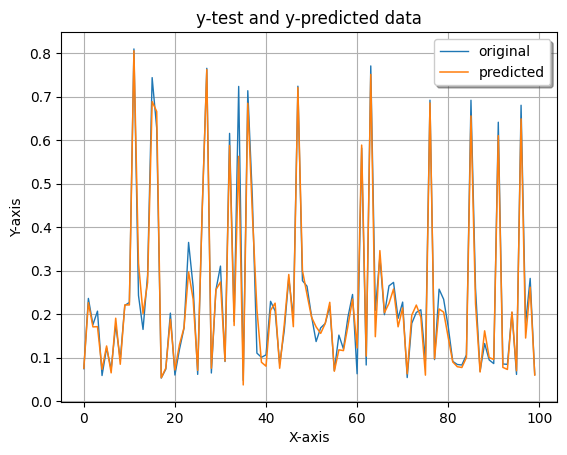

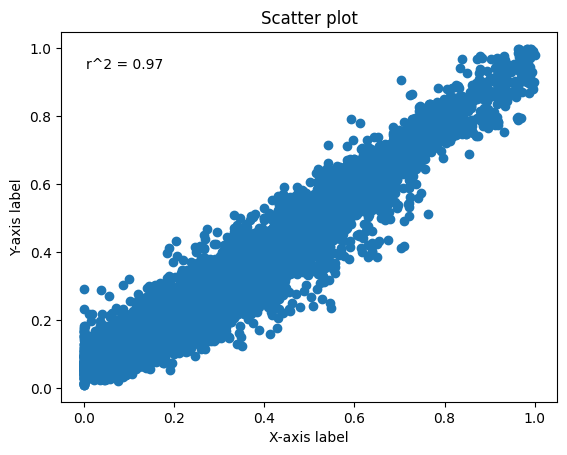

MSE:  0.0008686805406495554
RMSE:  0.0004343402703247777
0.019774330701186914
0.9747821533827697


In [106]:
start=tm.time()
ypred = model_12.predict(X_test)
ts_time=tm.time()-start
x_ax = range(len(y_test[0:100]))
plt.plot(x_ax, y_test[0:100], linewidth=1, label="original")
plt.plot(x_ax, ypred[0:100], linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 
plt.scatter(y_test, ypred)

# Add labels and title
plt.xlabel('X-axis label')
plt.ylabel('Y-axis label')
plt.title('Scatter plot')
r2 = sklearn.metrics.r2_score(y_test, ypred)
plt.annotate('r^2 = {:.2f}'.format(r2), xy=(0.05, 0.90), xycoords='axes fraction')

# Display the plot
plt.show()
mse = mean_squared_error(y_test, ypred)
print("MSE: ", mse)
print("RMSE: ", mse*(1/2.0)) 
mae=mean_absolute_error(y_test, ypred)
print(mean_absolute_error(y_test, ypred))

print(r2)

In [107]:
model_12.save("../result/10.29_pesudotime_predict/model/final_model_5_layer")

INFO:tensorflow:Assets written to: ../result/10.29_pesudotime_predict/model/final_model_5_layer/assets


INFO:tensorflow:Assets written to: ../result/10.29_pesudotime_predict/model/final_model_5_layer/assets
